In [10]:
import numpy as np
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [11]:
df = pd.read_csv("../data/purcheses.csv")

In [12]:
df

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,C19186,28.493517,1.000000,291.12,0.00,291.12,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,325.594462,48.886365,0.500000,6
8946,C19187,19.183215,1.000000,300.00,0.00,300.00,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,275.861322,NaN,0.000000,6
8947,C19188,23.398673,0.833333,144.40,0.00,144.40,0.000000,0.833333,0.000000,0.666667,0.000000,0,5,1000.0,81.270775,82.418369,0.250000,6
8948,C19189,13.457564,0.833333,0.00,0.00,0.00,36.558778,0.000000,0.000000,0.000000,0.166667,2,0,500.0,52.549959,55.755628,0.250000,6


In [13]:
df.isna().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [14]:
df.drop("MINIMUM_PAYMENTS" , axis=1 , inplace=True )
df.dropna(inplace = True)
df.isna().sum()

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

In [15]:
# remove outlier if any 
def remove_outliers_iqr_all(df):
    numeric_cols = df.select_dtypes(include='number').columns
    mask = pd.Series([True] * len(df), index=df.index)  

    for col in numeric_cols:
        data = df[col].dropna()
        q1 = data.quantile(0.25)
        q3 = data.quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr

        mask &= (df[col] >= lower) & (df[col] <= upper)

    return df[mask]  
print("Before cleaning", df.shape)
df = remove_outliers_iqr_all(df)
print("After cleaning", df.shape)

Before cleaning (8949, 17)
After cleaning (3180, 17)


In [16]:
from sklearn.impute import SimpleImputer
X = df.drop(['CUST_ID'], axis=1).values


In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [18]:
from sklearn.metrics import silhouette_score
# Range of gamma values to test
gamma_values = np.logspace(-3, 1, 10)  # from 0.001 to 10

best_gamma = None
best_score = -1

for gamma in gamma_values:
    # Apply Kernel PCA
    kpca = KernelPCA(n_components=2, kernel='rbf', gamma=gamma)
    X_kpca = kpca.fit_transform(X_scaled)
    
    # Cluster using KMeans
    kmeans = KMeans(n_clusters=3, random_state=42)
    labels = kmeans.fit_predict(X_kpca)
    
    # Evaluate with Silhouette Score
    score = silhouette_score(X_kpca, labels)
    print(f"Gamma: {gamma:.4f}, Silhouette Score: {score:.4f}")
    
    if score > best_score:
        best_score = score
        best_gamma = gamma

print(f"\nBest gamma: {best_gamma:.4f} with Silhouette Score: {best_score:.4f}")

Gamma: 0.0010, Silhouette Score: 0.3957
Gamma: 0.0028, Silhouette Score: 0.3957
Gamma: 0.0077, Silhouette Score: 0.4053
Gamma: 0.0215, Silhouette Score: 0.4343
Gamma: 0.0599, Silhouette Score: 0.4446
Gamma: 0.1668, Silhouette Score: 0.4915
Gamma: 0.4642, Silhouette Score: 0.7205
Gamma: 1.2915, Silhouette Score: 0.8651
Gamma: 3.5938, Silhouette Score: 0.9593
Gamma: 10.0000, Silhouette Score: 0.9836

Best gamma: 10.0000 with Silhouette Score: 0.9836


In [19]:
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=best_gamma)
X_kpca = kpca.fit_transform(X_scaled)
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_kpca)

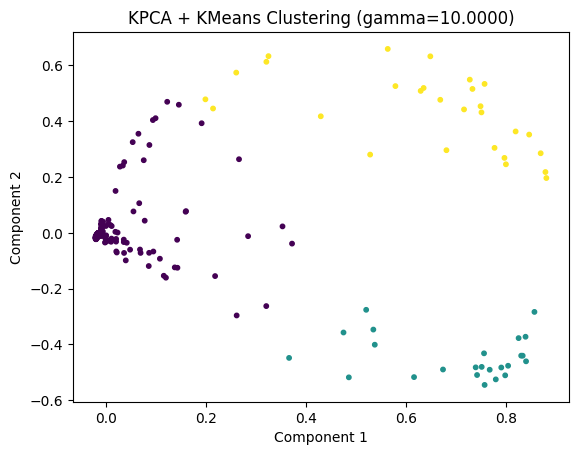

In [20]:

plt.scatter(X_kpca[:, 0], X_kpca[:, 1], c=labels, cmap='viridis', s=10)
plt.title(f"KPCA + KMeans Clustering (gamma={best_gamma:.4f})")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()